In [1]:
#As always, we import everything
import pandas as pd
import os
import re
import requests
from bs4 import BeautifulSoup
import numpy as np
from collections import OrderedDict
from tqdm import tqdm
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords as stop_words
from textblob import Word
import pycountry
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from gensim import corpora, models
import matplotlib.pyplot as plt
import json
import pickle
import lyricfetcher
import csv
import urllib
from urllib.request import urlopen, HTTPError
import langdetect
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

data_dir = './' + 'data'

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
year_artist_name_title_genre = pd.read_csv(os.path.join(data_dir + "/year_artist_name_title_genre.csv")).set_index('track_id')
final_dataframe = pd.read_csv("Final_With_Track_ID.csv")
final_dataframe.drop('Unnamed: 0', axis =1, inplace=True)
final_dataframe = final_dataframe[final_dataframe.year != 2010]
final_dataframe['decade'] = (final_dataframe['year'] // 10) * 10
def label_race (row):
    if row['genre'] == 'Latin' or row['genre'] == 'New Age' or row['genre'] == 'World':
        return 'Other'
    else: 
        return row['genre']
    
final_dataframe['GenreGroup'] = final_dataframe.apply(label_race, axis=1)

In [3]:
final_dataframe.head()

,year,artist_name,title,genre,labels,Class,decade,GenreGroup
0,1970,albert king,can't you see what you're doing to me,Blues,-1,Sexist,1970,Blues
1,1970,ann peebles,i still love you,RnB,-1,Sexist,1970,RnB
2,1970,atomic rooster,and so to bed,Rock,0,Neutral,1970,Rock
3,1970,atomic rooster,and so to bed,Rock,0,Neutral,1970,Rock
4,1970,atomic rooster,banstead,Rock,1,Feminist,1970,Rock


# 1. <a name="intro"></a>Introduction

Ever since the beginning of the 20th century, a number of political and social movements have arisen with the goal of empowering women and pushing for social equality of sexes. These movements serve as the foundation of modern day feminism. Numerous feminist ideologies have developed over the past half-century, and the topic certainly represents different viewpoints and aims which spark heated debates of both praises and criticism. Sexism on the other hand, is much less controversial and refers to any prejudice, stereotyping, or discrimination on the basis of sex, typically against women. 

Feminism empowers women, Sexism discriminates against women. The two seemingly opposing dynamics have been explored through various mediums by many aficionados. In this article, instead of approaching the topics from the conventional political, societal, or historical perspectives, we decided to look to music, particularly the lyrics of songs published over the last fifty years (or so) to seek insights. How were women depicted in the 1970s vs. 2000s? Are the images of women different for Rock vs. Rap music? Are there artists that are especially sexist or feminist? We hope to find the answers in the lyrics. 

The dataset we used for this project is the <a href="https://labrosa.ee.columbia.edu/millionsong/">Million Song Dataset</a> (MSD). However, we discovered that it only provides lyrics in tokenized format, and only includes the most frequently-occurring words. This is not ideal for analysis, and we decided to scrape the Internet for the full lyrics instead. We also looked to several playlists that are labelled as feminist-themed or sexist-themed by users, and used the songs as training data to create a Machine Learning model. The model is then applied to classify the songs in MSD as either Feminist, Sexist, or Neutral. We perform further analysis based on the classification and discuss the findings in thorough detail. 


# 2. What do you mean by Feminist / Sexist lyrics? 

Before we start calling songs feminist or sexist, a few things need to be clarified. First of all, what does it mean for lyrics to be sexist, feminist, or neutral? We shall define the meaning of these terms first. Second, what makes the lyrics of a song feminist or sexist? Lastly, how do we detect feminism or sexism in lyrics in order to classify it? We’ll address these questions in this section. 

Songs that are “explicitly” sexist are the most easily detectable. Explicit sexism is demonstrated by frequent usage of degrading terms towards women. This is commonly observed in Rap music. More subtle sexist songs however, are extremely hard to detect and can sometimes be confused with neutral songs. An example of this would be content such as objectification of women. Feminist lyrics are defined to include songs that portray women in a positive, loving, respectful, or empowering way. Neutral songs have lyrics that are neither sexist nor feminist. These songs either somehow depict women with neither positive nor negative connotation, or have nothing to do with women. 


To answer the second question, we decided to find songs that are labelled as feminist or sexist by internet users. We found such playlists and scraped internet for lyrics of these songs. For neutral lyrics, we looked to our own playlists to identify songs that fit the criteria, and scraped the lyrics for those songs. After converting lyrics from text to tf-idf feature vectors, we use scikit learn’s chi-square test to find the top 10 words that are the most correlated to each class. For feminist songs, it includes words like “worth”, “stronger”, “fix”, “respect” and “woman”. For sexist songs, unsurprisingly the list consists of degrading terms. Neutral songs show words that relate to other topics. We will perform the same test to all the songs in MSD we classify using the Machine Learning model we create, and expect to get similar results. 

In [4]:
pd.DataFrame({'Feminist':['girls','boys','woman','respect','mess','river','fix','uh','stronger','worth'],
             'Sexist':['dick','nigga','pussy','bitch','f*ck','ass','butt','body','baby','bitches'],
            'Neutral':['em','remember','dah','singing','lord','wanna','bitch','girls','girl','river']})


,Feminist,Sexist,Neutral
0,girls,dick,em
1,boys,nigga,remember
2,woman,pussy,dah
3,respect,bitch,singing
4,mess,f*ck,lord
5,river,ass,wanna
6,fix,butt,bitch
7,uh,body,girls
8,stronger,baby,girl
9,worth,bitches,river


 Everyone has their own interpretation of feminist or sexist lyrics. To avoid inherent bias that all humans possess, we have decided to let machine do the classification. With four machine learning models that are most commonly used for multi-class classification, we fit the training data to each model and use cross validation to compute the accuracies. The results are shown below, and LinearSVC() model clearly has more superior performance compared to the other three. The confusion matrix for this model is also displayed below. Note that the model generally performs well with the exception that it tends to confuse sexist songs with neutral songs. As mentioned earlier, some sexist lyrics are more subtle and may require a representation more complicated than tf-idf vectorization. We proceed to classification using the LinearSVC() model to complete the dataset we will perform analysis on. It contains 50991 songs, and for each song, in addition to its classification as either feminist, sexist or neutral, it also has the year, genre, artist, and title information.  

![title](accuracy_comp.png)
![title](conf_mat.png)

# The Big Picture

Most of the songs produced during the period of 1970s and 2000s are neutral (close to 70%), followed by feminist songs which consist of 28% of the whole dataset. It is pleasantly surprising that sexist songs only consist of 2.9%. However, it may be due to the limitation of the model. As mentioned previously, songs that are explicitly sexist are easy to detect, but some of the more subtle ones are sometimes confused with neutral songs. In reality, we expect the percentage of sexist music to be higher. 

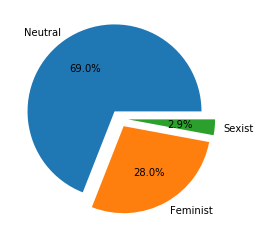

In [5]:
plt.pie(final_dataframe['Class'].value_counts(), autopct='%1.1f%%', labels = final_dataframe['Class'].value_counts().index.tolist(), explode= [0.1]*len(final_dataframe['Class'].value_counts()), radius = 1)
plt.savefig("bigpicture.svg")


A brief overview of number of feminist, neutral, and sexist songs are displayed in the graph below. We can see clearly here that significantly more data become available during recent years. We may need to account for this fact in our analysis later. Also, it is worth noticing that number of neutral songs and number of feminist songs are both steadily increasing throughout the year, where the number of sexist songs remain relatively constant. This means the proportion of sexist songs produced each year is getting lower. 


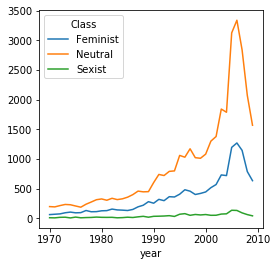

In [6]:
# increase size
count_through_year = final_dataframe.groupby(['year','Class']).size().unstack().plot(figsize = (4,4))
plt.savefig("counts.svg")


# Songs Between 1970s and 2000s

The Music industry is booming between the 1970s and 2000s. Talented artists emerge in all genres of music and many songs are still well-loved by today's audience. Rock was a dominating genre during this time period. As shown below, close to 50% of all songs are Rock songs. 

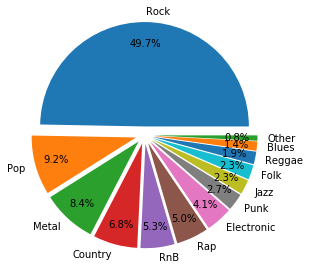

In [13]:
plot = plt.pie(final_dataframe['GenreGroup'].value_counts(), labels = final_dataframe['GenreGroup'].value_counts().index.tolist(), autopct='%1.1f%%', explode= [0.1]*len(final_dataframe['GenreGroup'].value_counts()), pctdistance = 0.8, radius = 1.2)

plt.savefig("genres.svg")

This may be due to the fast growth of rock music during the 1990s and 2000s. Rock, Electronic, and Pop are some of the other most popular music during the 2000s, followed by metal and Rap. 

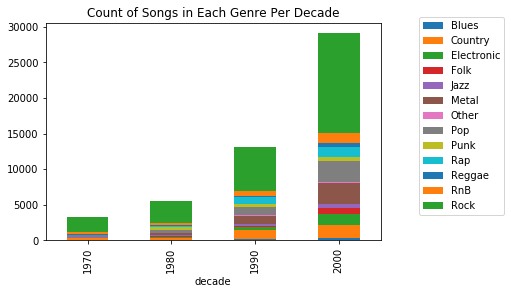

In [14]:
plot_decade_genre = final_dataframe.groupby(['decade', 'GenreGroup']).size().unstack().plot(kind='bar', title = 'Count of Songs in Each Genre Per Decade',stacked = True)
plot_decade_genre.legend(bbox_to_anchor=(1.1, 1.05) )


Across all genres, a significant growth in number of songs produced is experienced during the 1990s and 2000s. 

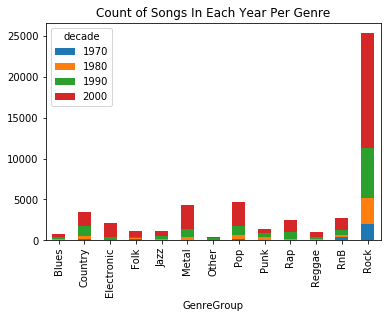

In [15]:
final_dataframe.groupby(['GenreGroup', 'decade']).size().unstack().plot(kind='bar', stacked = True, title = 'Count of Songs In Each Year Per Genre')

How many of these songs are feminist? It seems that Rock, Pop, Rap, and RnB has the most number of feminist songs within the genre. 

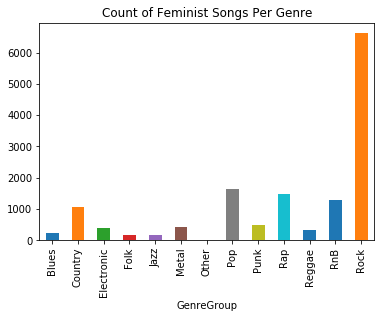

In [17]:
fem_count_per_genre = final_dataframe.loc[final_dataframe['Class'] == 'Feminist'].groupby(['GenreGroup']).size()#.plot()
fem = fem_count_per_genre.plot(kind = 'bar', title = 'Count of Feminist Songs Per Genre')
plt.savefig("femgenre.svg")

What about sexist songs? Unsurprisingly, Rap music tops the list by having the highest count. Followed by RnB, Rock, and Pop. 

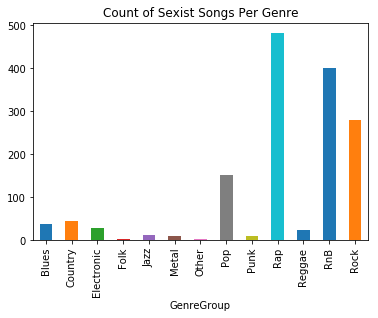

In [18]:
sexist_count_per_genre = final_dataframe.loc[final_dataframe['Class'] == 'Sexist'].groupby(['GenreGroup']).size()#.plot()
sexist = sexist_count_per_genre.plot(kind = 'bar', title = 'Count of Sexist Songs Per Genre')
plt.savefig("sexgenre.svg")

Number of feminist or sexist songs is only one side of the story. Since there are significantly more Rock songs present in the dataset, it makes sense that there is a higher number of feminist Rock songs than say, feminist Folk music. We chose four genres that interest us the most, and investigate the dynamics of feminism and sexism and their progression throughout the years. 

## Pop Music

As the name suggests, Pop Music, or popular music aims to appeal to general audience, as opposed to a particular sub-culture or ideology. Pop Music is progressive, and tends to reflect changes experienced by the society. There is a clear increasing trend in the proportion of feminist music produced each year for this genre. The increase in presence of feminist songs are likely influenced by several notable Feminism movements that happened during this period of time. From Gloria Steinem's women's liberation movements and Yoko Ono's famous essay, "The Feminization of Society" during the 70s, to ladies like Oprah Winfrey, Beyoncé, and Madonna continue to voice their opinions through media and breaking gender stereotypes, pop culture is constantly evolving, and will continue to empower women and encourage them to grow, develop and thrive. 

Explicit sexism is frowned upon in Pop music and may receive serious PR backlashes. Most artists refrain from demonstrating explicit sexism in their songs, which explains the lack sexist songs in this genre. Many sexist pop songs are disguised as neutral or might even be identified as 'Feminist' by this model. Here's an example: Just the way you are by Bruno Mars. The model will pick up on how women are portrayed in a positive and loving way in this music. However, when a male artist writes a song about how he is deeply attracted to a woman entirely based on her eyes, her hair, her face and her lips, would you say it has a sexist undertone underneath the loving depiction of women? Even though this is beyond the scope of the definition of feminist and sexist within this article, and it would take a much more complicated Machine Learning model to detect, we thought it was an interesting things to consider. 

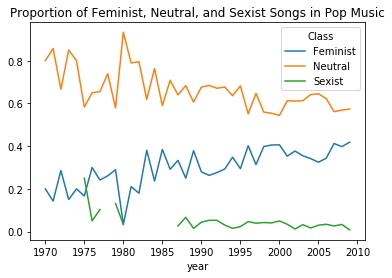

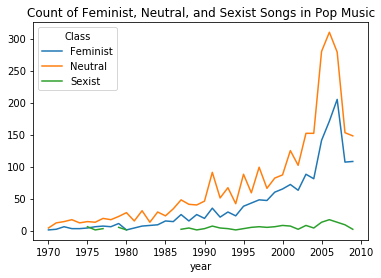

In [21]:
# Pop music: proportion of feminist, sexist and neutral songs over years 
Pop_count = final_dataframe.loc[final_dataframe['GenreGroup'] == 'Pop'].groupby(['year','Class']).size()#.unstack().plot()

Pop1 = final_dataframe.loc[final_dataframe['GenreGroup'] == 'Pop'].groupby('year', as_index=False)['Class'].size()

Pop_proportion = Pop_count / Pop1
Pop_proportion.unstack().plot(title = 'Proportion of Feminist, Neutral, and Sexist Songs in Pop Music')
plt.savefig("popprop.svg")
Pop_count.unstack().plot(title = 'Count of Feminist, Neutral, and Sexist Songs in Pop Music')

Overall, the result is very positive for Pop Music. With the recent "MeToo" movement gone viral on social media and the universal nature of fourth-wave feminism, we expect to see more feminist songs and less sexist songs in this genre. 

After seeing such positive result, let us switch gear and investigate the genre that we expect to be the most sexist. 

## Rap Music

Rap Music, or Hip Hop music may be known for being passionate, inspirational, expressive, or in today's linguistics, <a href="https://www.urbandictionary.com/define.php?term=lit">"lit"</a> or <a href="https://www.urbandictionary.com/define.php?term=fire">"fire"</a>, it is certainly not known for being respectful to women. Many songs from the sexist playlists we scraped are Rap songs. We hypothesized that this would be the genre with the highest proportion of sexist songs before any analysis is done.

Rap music originated from African-American youths living in New York in the 1970s. They were disenfranchised, living in low-income areas, and are of marginalized backgrounds. Rap music was their way of coping with tough situations. Their struggles and the political oppression they constantly experience were also reflected in the hip hop culture, as some of the most popular topics rapped about back then included sex and bitches/prostitutes, dollar bills, violence and drugs. 

According to Mazlov's hierachy of needs, self-fulfillment needs and psychological needs such as achieving one's purpose in life or developing healthy intimate relationships with others only become needs when more basic needs such as safety, security and food needs are satisfied. Many rappers lived in environments that were dangerous or unstable, where women they were exposed to were treated like commodities or some source of income. 

However, this is not to say that all rap songs are sexist. Some of the most inspirational lyrics ever written come from rap music. Tupac talks about his struggles in the song, Me Against The World, where he writes that "No matter how hard it gets, stick your chest out, keep your head up and handle it". Female rapper Aaliyah also writes in her song Try Again that "And if at first you don’t succeed then dust yourself off and try again". Even though the proportion of sexist songs are high in rap music, we see a decrease in percentage over recent years. Though some form of misogyny will still persist in the foreseeable future for such an alpha-male-dominated culture, with emerging artists like Cardi B (yes, she's a feminist),Angel Haze and Princess Nokia expressing themselves and confronting the oppresion faced by women, they are certainly making positive impacts to the hip hop culture. 



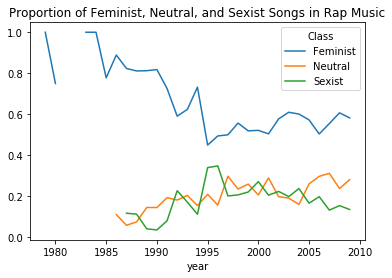

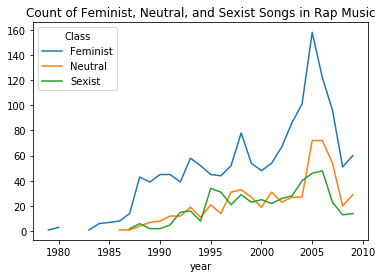

In [32]:
# Rap music: proportion of feminist, sexist and neutral songs over years 
Rap_count = final_dataframe.loc[final_dataframe['GenreGroup'] == 'Rap'].groupby(['year','Class']).size()#.unstack().plot()

Rap1 = final_dataframe.loc[final_dataframe['GenreGroup'] == 'Rap'].groupby('year', as_index=False)['Class'].size()

Rap_proportion = Rap_count / Rap1
Rap_proportion.unstack().plot(title = 'Proportion of Feminist, Neutral, and Sexist Songs in Rap Music')

Rap_count.unstack().plot(title = 'Count of Feminist, Neutral, and Sexist Songs in Rap Music')

# Rock Music

We can see that Rock music is fairly feminist, having a steady increase of women empowering songs. Although the proportion of the latter varies throughout the years, it does not leave the 20% ~ 30% interval. Again, we should be wary of the unability of our classifier to recognize subtle sexist songs. Here's an interesting fact: Pop music and Rock music were roughly synonymous terms until the late 1960s. It is only since the 1970s that they became increasingly differentiated from each other.

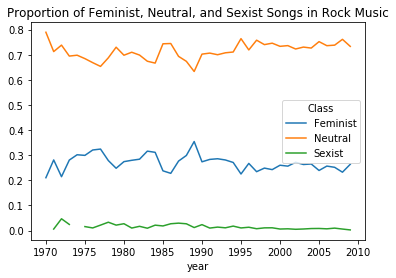

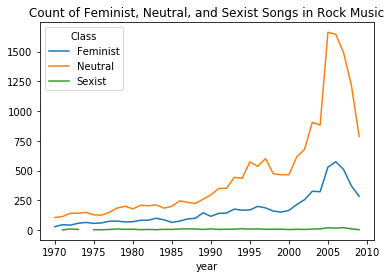

In [33]:
# Rock music: proportion of feminist, sexist and neutral songs over years 
Rock_count = final_dataframe.loc[final_dataframe['GenreGroup'] == 'Rock'].groupby(['year','Class']).size()#.unstack().plot()

Rock1 = final_dataframe.loc[final_dataframe['GenreGroup'] == 'Rock'].groupby('year', as_index=False)['Class'].size()

Rock_proportion = Rock_count / Rock1
Rock_proportion.unstack().plot(title = 'Proportion of Feminist, Neutral, and Sexist Songs in Rock Music')

Rock_count.unstack().plot(title = 'Count of Feminist, Neutral, and Sexist Songs in Rock Music')


# RnB Music

RnB songs are much more varying throughout the years. Is it because this genre is so hesitating between empowering women and degrading them? Or is it because there is a substantial number of women performing in this genre? Well, this is hard to answer since, with a careful look at the plots, we have few RnB songs in our dataset. This genre is quite young and flourished starting from late 2000 ( where we do not have a lot of tracks). However, with emergence of feminist artists like Janelle Monáe, it will likely become more feminist.


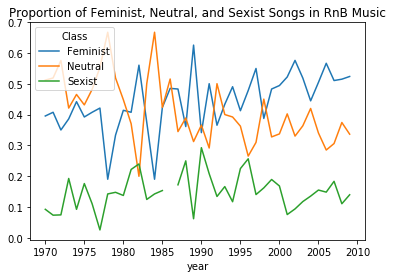

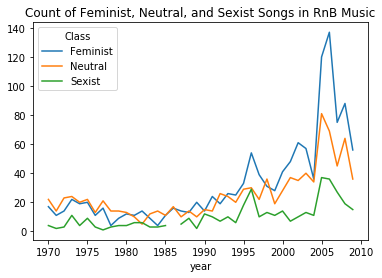

In [34]:
# RnB music: proportion of feminist, sexist and neutral songs over years 
RnB_count = final_dataframe.loc[final_dataframe['GenreGroup'] == 'RnB'].groupby(['year','Class']).size()#.unstack().plot()

RnB1 = final_dataframe.loc[final_dataframe['GenreGroup'] == 'RnB'].groupby('year', as_index=False)['Class'].size()

RnB_proportion = RnB_count / RnB1
RnB_proportion.unstack().plot(title = 'Proportion of Feminist, Neutral, and Sexist Songs in RnB Music')

RnB_count.unstack().plot(title = 'Count of Feminist, Neutral, and Sexist Songs in RnB Music')

# Metal Music ... Out of Curiosity :)

Notice the absence of both feminist and sexist songs? Well, everybody knows it, women is not the most popular topic of metal music. Metal artists are concerned about bigger things, such as the meaning of life, death, depression, and other pains of humankind.

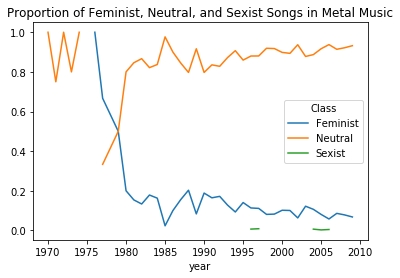

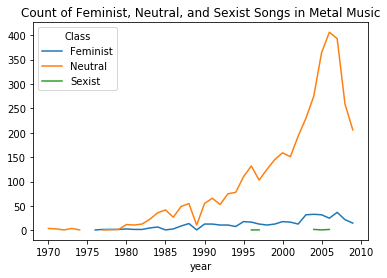

In [35]:
# Metal music: proportion of feminist, sexist and neutral songs over years 
Metal_count = final_dataframe.loc[final_dataframe['GenreGroup'] == 'Metal'].groupby(['year','Class']).size()#.unstack().plot()

Metal1 = final_dataframe.loc[final_dataframe['GenreGroup'] == 'Metal'].groupby('year', as_index=False)['Class'].size()

Metal_proportion = Metal_count / Metal1
Metal_proportion.unstack().plot(title = 'Proportion of Feminist, Neutral, and Sexist Songs in Metal Music')

Metal_count.unstack().plot(title = 'Count of Feminist, Neutral, and Sexist Songs in Metal Music')

# The Most Feminist vs. The Most Sexist Artists

In [19]:
artists_labels = final_dataframe.groupby('artist_name').sum().labels.sort_values(ascending=True)
top_sexist = pd.DataFrame(artists_labels[0:9], index=artists_labels[0:9].index)
top_feminist = pd.DataFrame(artists_labels[7647:], index=artists_labels[7647:].index)
top_sexist_feminist = pd.concat([top_sexist,top_feminist])

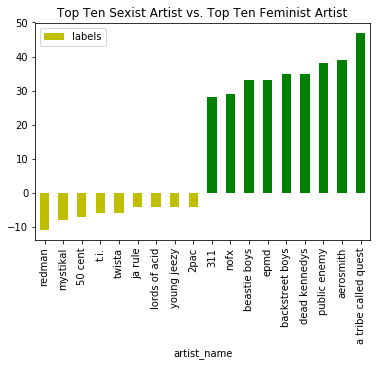

In [36]:
top_sexist_feminist.plot(kind='bar', color = 'yyyyyyyyyggggggggg', title = "Top Ten Sexist Artist vs. Top Ten Feminist Artist")

What a surprise ! Redman and 50 cent are the most sexist singers in the msd dataset. Rap musicians are known for being sexist and this is further shown in our plot. On the other hand, the highest feminism scores are found in rock music. Aerosmith are extremely influential and popular bands which are known for being quite feminist.

'A tribe called quest', a band known for its inspiring, well-thought songs and for being regarded as the most intelligent, artistic rap group during the 1990s, is at the top of feminist battle. This is important to us since it shows that there are Hip Hop artists who aim at promoting gender and racial equality.

# Just for fun... Battle of Feminism vs. Sexism 

We would like to mark the end of our analysis with a fun visualization of the battle between feminism and sexism throughout the years. In our dataset, a sexist song is marked -1, a neutral song is marked 0, and a feminist song is marked 1. We thought it would be interesting to visualize the NFE: Net Feminist Energy for every year between 1970 and 2009. For instance, in 1970, there are 7 sexist songs, 195 neutral songs, and 60 feminist songs which would give it an overall NFE of 53. The result is displayed below: 


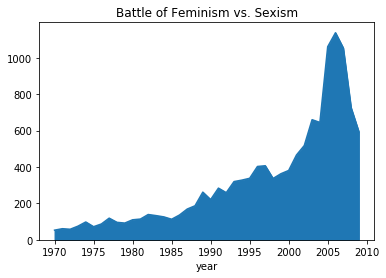

In [37]:
battle = final_dataframe.groupby(['year', 'labels']).size()
#print(a) #eg. in 1970, 7 sexist songs, 195 neutral, 60 feminist => overall score (sum) 53

battle_per_year = final_dataframe.groupby(['year'])['labels'].sum().plot(kind = "Area", title = "Battle of Feminism vs. Sexism")

As expected, there is a positive trend and no year shows a negative value. Advocacy for women's rights on the ground of the equality of the sexe is by no means a new idea, and countless remarkable females have contributed to such movements and ideologies. As early as 1903, female scientist Marie Curie broke gender stereotype in academia with her pioneer discovery of polonium, a radioactive element. In addition to the important figures mentioned in the Pop Music section, artists like Nina Simone and musicians like Lady Gaga joined the fights with their remarkable artistic career and unbending fight for women empowerment. The graph above is a perfect representation of the ever-lasting battle that feminists are facing and winning, and the surge in 2005 especially owes it to the work of feminist artists who are brave enough to stand up and let their voices be heard.  


# Closing Remarks

Like Rapper Ice Cube said in his 2015 hit "Straight Outta Compton", our art is a reflection of our reality. Art, Music, Literature and Philosophy are the mirrors of each generation, and allow our descendants to have a sneak peak into the days of our lives. As our society influences the music and art industries, at the same time, it is influenced by the music and art we create. Feminism vs. Sexism is just one topic that we could gain further understanding from music and lyrics, there are many others that we would like to explore. 

Until next time :)!

# What could be improved?

In this article, we have challenged ourselves to analyze the evolution of feminism and sexism throughout the history of music. However, music is art, art is complex, and so are our research questions. We have designed, developped and implemented a dataanalysis and machine learning pipeline to present first insights about this fascinating topic. However, we have had to face several issues that otherwise would have improved our results and widened the scope of our answers. First, we had a limited number training songs: we did not find a sufficient number of feminist/sexist themed songs, and we believe our model's accuracy was negatively affected by this issue. Second, our predictive algorithm was quite simple. It looks for correlation between the label and unigrams and bigrams using the tf-idf ventorized representation of lyrics. One significant shortfall of this method is that the context of such unigram and bigrams are removed from a sentence, and some information is lost in translation. Lastly, we could not figure out a way for Github's hosting website to allow for dynamic widgets and our plotly graphs that allow interaction with users could not be used. The inability to allow for better visualization hinders our ability to deliver clear messages to our audience. Perhaps next time we can work with html which allows for more flexibility with the way plots are presented.

